# 50.039 Deep Learning Project

Group Members:
- Lee Chang Zheng
- Lee Cheng Xin
- Jason Peng Jing Ming

## Imports and CUDA

In [16]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchaudio import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import librosa

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# Set the seed
seed = 12
torch.manual_seed(seed)

## Converting Audio samples into Spectrograms

Before we can begin, we first have to convert the audio samples from .webm format into a standardised format. We will convert the files to .wav with single channel, a sample rate of 48000 Hz, and pad the audio files to 10 seconds long. 

In [4]:
# Convert webm and ogg files to wav with single channel, sample rate of 48000 Hz, padded to 10 seconds long
import subprocess
from pydub import AudioSegment
import os

def convert_audio(in_path, out_path):
    if '.webm' in in_path:
        subprocess.run(["ffmpeg", "-i", in_path, "-y", "-ac", "1", "-ar", "48000", out_path.replace('.webm', '.wav')])
    elif '.ogg' in in_path:
        subprocess.run(["ffmpeg", "-i", in_path, "-y", "-ac", "1", "-ar", "48000", out_path.replace('.ogg', '.wav')])

def pad_trim_audio(in_path, out_path):
    audio = AudioSegment.from_wav(in_path)
    if len(audio) < 10000:
        padding = AudioSegment.silent(duration=10000 - len(audio))
        padded_audio = audio + padding
        padded_audio.export(out_path, format='wav')
    elif len(audio) > 10000:
        trimmed_audio = audio[:10000]
        trimmed_audio.export(out_path, format='wav')
    
# Note: These are commented out as the conversion has been done, it is simply for reference. You will need FFmpeg to run this.
# for filename in os.listdir('./Data/Covid'):
#     convert_audio(f'./Data/Covid/{filename}', f'./Converted/{filename}')
# for filename in os.listdir('./Data/Healthy'):
#     convert_audio(f'./Data/Healthy/{filename}', f'./Converted/{filename}')

# # Padding/trimming the audio to 10 seconds long
# for filename in os.listdir('./Converted'):
#     pad_trim_audio(f'./Converted/{filename}', f'./Converted/{filename}')

d:\School Work\Term 8\Deep Learning\project\code\50.039-DL-Project\venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


After standardizing the audio samples, we need to convert them into a Mel Spectrogram for the CNN model to process. 

In [6]:
# Converts the audio waveform into a spectrogram
def audio_to_spec(audio, sample_rate, n_mels=128, n_fft=400, win_length=None, hop_length=None, top_db=80):
    mel_spectrogram = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        n_mels=n_mels,
    )
    
    melspec = mel_spectrogram(audio)
    
    transform = transforms.AmplitudeToDB(top_db=top_db)
    final_spec = transform(melspec)
    return final_spec

We can visualise the spectrogram using the code below

## Custom Dataset and Dataloader

We create a custom dataset for the model. The custom dataset will convert the audio into a spectrogram before feeding it into the model. It will also ensure that the dimensions of the spectrograms are consistent, trimming and padding any spectrogram image that is too long or too short.

In [14]:
class CovidCoughDataset(Dataset):
    def __init__(self, filename, datapath):
        df = pd.read_excel(filename)
        self.df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
        self.datapath = datapath
        self.max_spec_length = 2400

    def __getitem__(self, index):
        audio_file = self.datapath + self.df.iloc[index, 0] + '.wav'
        status = 1 if self.df.iloc[index, 1] == 'COVID' else 0        
        audio, sample_rate = torchaudio.load(audio_file)
        spec = audio_to_spec(audio=audio, sample_rate=sample_rate)
        
        # Note: There might be some minor differences in the length of the audio clips, resulting in spectrograms of different
        #       dimensions. We need to pad/trim the spectrograms to ensure consistency before we can feed into the model. 
        # Pad the shorter spectrograms to the maximum length
        if spec.shape[2] < self.max_spec_length:
            spec = F.pad(spec, (0, self.max_spec_length - spec.shape[2]), value=0)
        # Trim the longer spectrograms to the maximum length
        elif spec.shape[2] > self.max_spec_length:
            spec = spec[:, :, :self.max_spec_length]
        return spec, status
        
    def __len__(self):        
        return len(self.df)
    
    def visual_spectrogram(self,index):
        audio_file = self.datapath + self.df.iloc[index, 0] + '.wav'
        # status = 1 if self.df.iloc[index, 1] == 'COVID' else 0        
        audio, sample_rate = torchaudio.load(audio_file)
        spec = audio_to_spec(audio=audio, sample_rate=sample_rate)
        if spec.shape[2] < self.max_spec_length:
            spec = F.pad(spec, (0, self.max_spec_length - spec.shape[2]), value=0)
        # Trim the longer spectrograms to the maximum length
        elif spec.shape[2] > self.max_spec_length:
            spec = spec[:, :, :self.max_spec_length]

        fig, axs = plt.subplots(2, 1)
        plot_waveform(audio, sample_rate, title="Original waveform", ax=axs[0])
        plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
        fig.tight_layout()

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")



d:\School Work\Term 8\Deep Learning\project\code\50.039-DL-Project\venv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([1, 128, 2400])
None


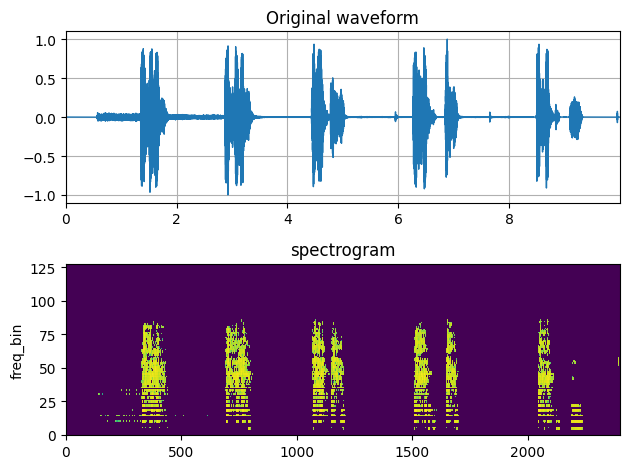

In [19]:
# Load the dataset
batch_size = 32

dataset = CovidCoughDataset('./Data/Dataset.xlsx', './Converted/')
print(dataset[0][0].shape)
print(dataset.visual_spectrogram(300))
train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
class CovidClassifer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=3)

        # Fully connected layers
        # Note: Each spectrogram is 128 x 2400. We divide by 9 as there are two 3 by 3 kernels with stride 1 and padding 1. 
        self.fc1 = nn.Linear(64 * (128//27) * (2400//27), 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        
        # Flattens the 2D images into 1D
        x = x.view(-1, 64 * (128//27) * (2400//27))
        x = self.fc1(x)
        
        return x

In [ ]:
def evaluate(model, test_dataloader):
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize epoch loss and accuracy
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
    # Calculate epoch loss and accuracy
    total_loss /= len(test_dataloader)
    accuracy = correct/total
    
    return total_loss, accuracy

In [ ]:
def train(model, train_dataloader, valid_dataloader, epochs = 10, lr = 0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        
        model.train()
        
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_number, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_dataloader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
    
        epoch_loss, epoch_acc = evaluate(model, valid_dataloader)    
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Validation loss: {epoch_loss:.4f}, Validation accuracy: {epoch_acc:.4f}')            
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [ ]:
model = CovidClassifer().to(device)

train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, epochs = 3, lr = 0.001)

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train_losses, "r-", label = "Train losses")
plt.plot(valid_losses, "b-", label = "Validation losses")
plt.legend(loc = "best")
plt.show()

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train_accuracies, "r-", label = "Train accuracy")
plt.plot(valid_accuracies, "b-", label = "Validation accuracy")
plt.legend(loc = "best")
plt.ylim([0, 1])
plt.show()

In [ ]:
loss, accuracy = evaluate(model, test_dataloader)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")